# Adaptive Signal POD using Kriging

In [1]:
# import relevant module
import openturns as ot
import otpod
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# enable display figure in notebook
try:
    %matplotlib inline
except:
    pass

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Generate data

In [2]:
inputSample = ot.Sample(
    [[4.59626812e+00, 7.46143339e-02, 1.02231538e+00, 8.60042277e+01],
    [4.14315790e+00, 4.20801346e-02, 1.05874908e+00, 2.65757364e+01],
    [4.76735111e+00, 3.72414824e-02, 1.05730385e+00, 5.76058433e+01],
    [4.82811977e+00, 2.49997658e-02, 1.06954641e+00, 2.54461380e+01],
    [4.48961094e+00, 3.74562922e-02, 1.04943946e+00, 6.19483646e+00],
    [5.05605334e+00, 4.87599783e-02, 1.06520409e+00, 3.39024904e+00],
    [5.69679328e+00, 7.74915877e-02, 1.04099514e+00, 6.50990466e+01],
    [5.10193991e+00, 4.35520544e-02, 1.02502536e+00, 5.51492592e+01],
    [4.04791970e+00, 2.38565932e-02, 1.01906882e+00, 2.07875350e+01],
    [4.66238956e+00, 5.49901237e-02, 1.02427200e+00, 1.45661275e+01],
    [4.86634219e+00, 6.04693570e-02, 1.08199374e+00, 1.05104730e+00],
    [4.13519347e+00, 4.45225831e-02, 1.01900124e+00, 5.10117047e+01],
    [4.92541940e+00, 7.87692335e-02, 9.91868726e-01, 8.32302238e+01],
    [4.70722074e+00, 6.51799251e-02, 1.10608515e+00, 3.30181002e+01],
    [4.29040932e+00, 1.75426222e-02, 9.75678838e-01, 2.28186756e+01],
    [4.89291400e+00, 2.34997929e-02, 1.07669835e+00, 5.38926138e+01],
    [4.44653744e+00, 7.63175936e-02, 1.06979154e+00, 5.19109415e+01],
    [3.99977452e+00, 5.80430585e-02, 1.01850716e+00, 7.61988190e+01],
    [3.95491570e+00, 1.09302814e-02, 1.03687664e+00, 6.09981789e+01],
    [5.16424368e+00, 2.69026464e-02, 1.06673711e+00, 2.88708887e+01],
    [5.30491620e+00, 4.53802273e-02, 1.06254792e+00, 3.03856837e+01],
    [4.92809155e+00, 1.20616369e-02, 1.00700410e+00, 7.02512744e+00],
    [4.68373805e+00, 6.26028935e-02, 1.05152117e+00, 4.81271603e+01],
    [5.32381954e+00, 4.33013582e-02, 9.90522007e-01, 6.56015973e+01],
    [4.35455857e+00, 1.23814619e-02, 1.01810539e+00, 1.10769534e+01]])

signals = ot.Sample(
    [[ 37.305445], [ 35.466919], [ 43.187991], [ 45.305165], [ 40.121222], [ 44.609524],
     [ 45.14552 ], [ 44.80595 ], [ 35.414039], [ 39.851778], [ 42.046049], [ 34.73469 ],
     [ 39.339349], [ 40.384559], [ 38.718623], [ 46.189709], [ 36.155737], [ 31.768369],
     [ 35.384313], [ 47.914584], [ 46.758537], [ 46.564428], [ 39.698493], [ 45.636588],
     [ 40.643948]])

# detection threshold
detection = 38

# Select point as initial DOE
inputDOE = inputSample[:7]
outputDOE = signals[:7]

# simulate the true physical model
basis = ot.ConstantBasisFactory(4).build()
covModel = ot.SquaredExponential([5.03148,13.9442,20,20], [15.1697])
krigingModel = ot.KrigingAlgorithm(inputSample, signals, covModel, basis)
krigingModel.run()
physicalModel = krigingModel.getResult().getMetaModel()

## Create the Adaptive Signal POD with Kriging model

This method aims at improving the quality of the Kriging model where the 
accuracy of the computed POD is the lowest.

As this method is time consuming, it is more efficient to reduce the
area of the defect size only in the most interesting part. To do that,
an initial POD study can be run.

#### Run an initial POD study with the kriging technique

In [3]:
initialPOD = otpod.KrigingPOD(inputDOE, outputDOE, detection)
initialPOD.run()

Start optimizing covariance model parameters...
Kriging optimizer completed
kriging validation Q2 (>0.9): 0.8851
Computing POD per defect: [==================================================] 100.00% Done


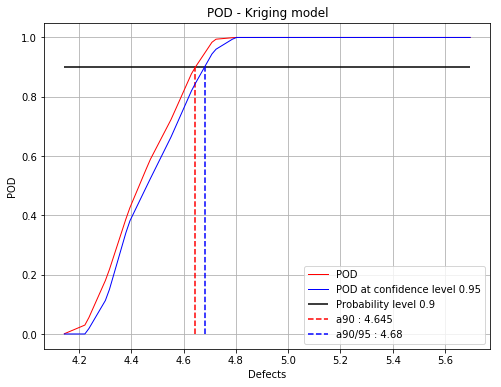

In [4]:
fig, ax = initialPOD.drawPOD(0.9, 0.95)
fig.show()

Based on this study, the interesting part for the defects ranges from 4.2 to 4.8. The adaptive signal algorithm will be then reduced to this area.

#### Run the adaptive algorithm

Computing the criterion is costly so the sampling and simulation size are reduced.

Building the kriging model
Optimization of the covariance model parameters...
Kriging validation Q2 (>0.9): 0.8851

Iteration : 1/5
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0696
Added point : [4.60781,0.0672393,1.04482,51.7969]
Update the kriging model
Optimization of the covariance model parameters...
Kriging validation Q2 (>0.9): 0.9859


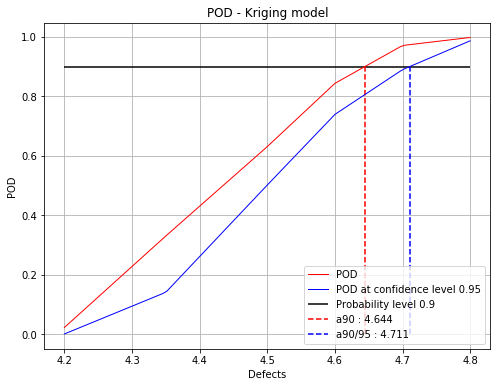

Iteration : 2/5
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0500
Added point : [4.45312,0.0323814,1.03339,61.4782]
Update the kriging model
Optimization of the covariance model parameters...
Kriging validation Q2 (>0.9): 0.9775


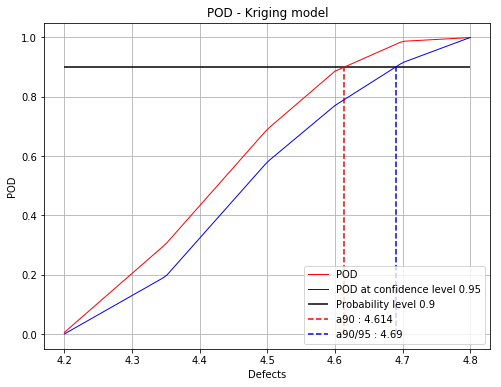

Iteration : 3/5
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0416
Added point : [4.6875,0.0610879,1.04298,8.55362]
Update the kriging model
Kriging validation Q2 (>0.9): 0.9602


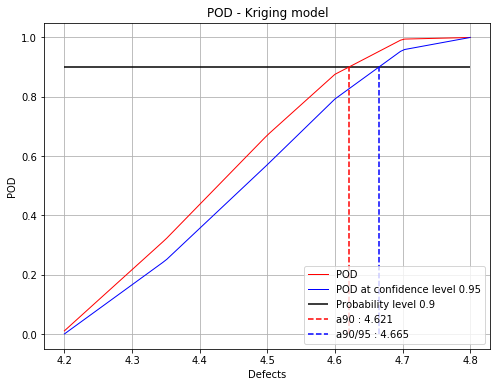

Iteration : 4/5
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0343
Added point : [4.275,0.0578072,1.06364,75.6775]
Update the kriging model
Kriging validation Q2 (>0.9): 0.9745


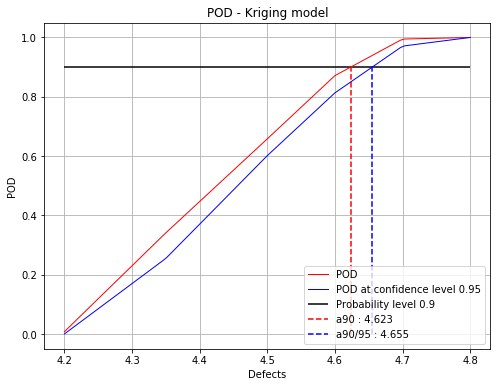

Iteration : 5/5
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0273
Added point : [4.3125,0.0414035,1.03708,60.1874]
Update the kriging model
Kriging validation Q2 (>0.9): 0.9720


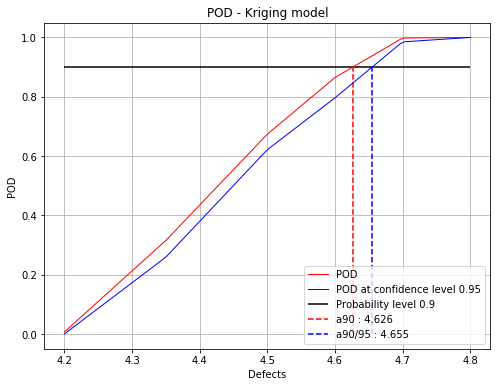


Start computing the POD with the last updated kriging model
Computing POD per defect: [==================================================] 100.00% Done


In [5]:
# set the number of iterations
nIteration = 5

# Creating the adaptivePOD object
adaptivePOD = otpod.AdaptiveSignalPOD(inputDOE, outputDOE, physicalModel, nIteration, detection)

# Change the range for the defect sizes between 4.2 and 4.8
adaptivePOD.setDefectSizes([4.2, 4.35, 4.5, 4.6, 4.7, 4.8])

# We can change also the number of candidate points for which the critertion is computed
adaptivePOD.setCandidateSize(100)
# we can change the sample size of the Monte Carlo simulation
adaptivePOD.setSamplingSize(500) # default is 5000
# we can also change the size of the simulation to compute the confidence interval
adaptivePOD.setSimulationSize(100) # default is 1000

# The current iteration POD graph can be displayed with multiple options :
## with or without the confidence level curve 
## and with or without the intersection value at the given probability level
## if a directory is given, all graphs are saved as AdaptiveSignalPOD_i.png
adaptivePOD.setGraphActive(graphVerbose=True, probabilityLevel=0.9, confidenceLevel=0.95,
                           directory='figure/')

adaptivePOD.run()

### Display the POD result based on the adative kriging model

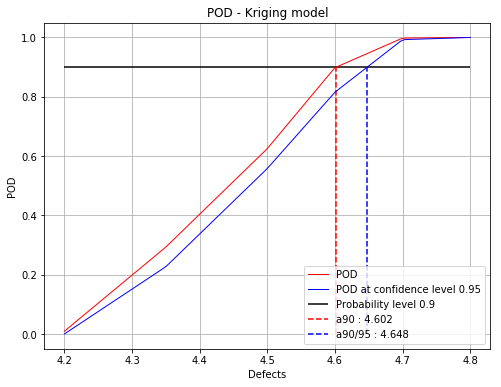

In [6]:
fig, ax = adaptivePOD.drawPOD(0.9, 0.95)
fig.show()

### Diplay the validation graph

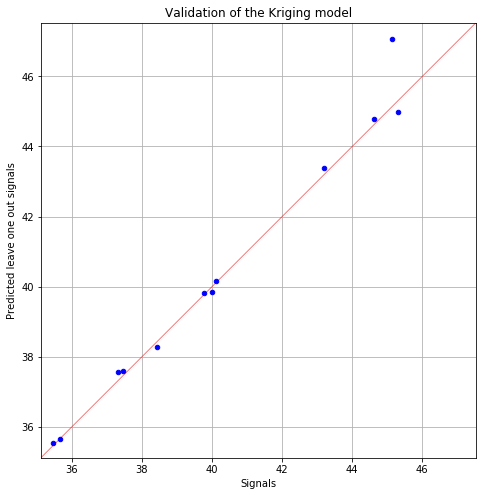

In [7]:
fid, ax = adaptivePOD.drawValidationGraph()
fig.show()

### Quality improvement of the POD computation

From the adaptive algorithm, the kriging result and the final DOE are available. As the number of simulations were reduced, we can compute again the POD with more accuracy than before if needed.

In [8]:
# get the kriging result and the final DOE from the adaptive algorithm
krigingRes = adaptivePOD.getKrigingResult()
inputfinal = adaptivePOD.getInputDOE()
outputfinal = adaptivePOD.getOutputDOE()
defectSizes = adaptivePOD.getDefectSizes()

# A new POD study is launch with the DOE values
finalPOD = otpod.KrigingPOD(inputfinal, outputfinal, detection)
finalPOD.setDefectSizes(defectSizes)
# The kriging model is already known so it is given to this study
finalPOD.setKrigingResult(krigingRes)
finalPOD.run()

kriging validation Q2 (>0.9): 0.9720
Computing POD per defect: [==================================================] 100.00% Done


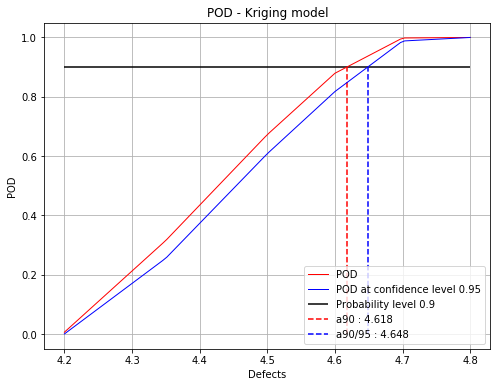

In [9]:
fig, ax = finalPOD.drawPOD(0.9, 0.95)
fig.show()